### Import Libraries

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn import metrics

from tqdm.auto import tqdm
import xgboost as xgb
from xgboost import XGBClassifier


### Data preparation and data clearning

**Some observation:**

According to the introduction of the competition, the data is interpreted as follows:
- `id`: Unique identifier for each data point.
- `age`: Age of the individual, categorized in 5-year intervals.
- `height(cm)`: Height of the individual in centimeters.
- `weight(kg)`: Weight of the individual in kilograms.
- `waist(cm)`: Waist circumference of the individual in centimeters.
- `eyesight(left/right)`: Eyesight measurements for the left and right eyes.
- `hearing(left/right)`: Hearing ability for the left and right ears, represented as binary.
- `systolic`: Systolic blood pressure measurement.
- `relaxation`: Diastolic blood pressure measurement.
- `fasting blood sugar`: Fasting blood sugar level.
- `Cholesterol`: Total cholesterol level.
- `triglyceride`: Triglyceride level.
- `HDL`: High-density lipoprotein cholesterol level.
- `LDL`: Low-density lipoprotein cholesterol level.
- `hemoglobin`: Hemoglobin level in the blood.
- `Urine protein`: Level of protein in urine, categorized.
- `serum creatinine`: Serum creatinine level.
- `AST`: Level of aspartate aminotransferase enzyme.
- `ALT`: Level of alanine aminotransferase enzyme.
- `Gtp`: Level of gamma-glutamyl transferase enzyme.
- `dental caries`: Presence (1) or absence (0) of dental cavities.
- `smoking`: Target variable indicating if the individual is a smoker (1) or not (0).

In [40]:
df = pd.read_csv('smoker_train_dataset.csv')
pg = pd.read_csv('train.csv') 
df.shape , pg.shape

((38984, 23), (159256, 24))

In [41]:
df = pd.concat([pg, df])
df.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0.0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1.0,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2.0,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3.0,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4.0,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1


In [42]:
df.drop(columns=['id'], inplace=True)

In [43]:
def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['missing #'] = df.isna().sum()
    sum['missing %'] = (df.isna().sum())/len(df)
    sum['uniques'] = df.nunique().values
    sum['count'] = df.count().values
    return sum
summary(df)

,dtypes,missing #,missing %,uniques,count
age,int64,0,0.0,18,198240
height(cm),int64,0,0.0,15,198240
weight(kg),int64,0,0.0,29,198240
waist(cm),float64,0,0.0,548,198240
eyesight(left),float64,0,0.0,20,198240
eyesight(right),float64,0,0.0,18,198240
hearing(left),int64,0,0.0,2,198240
hearing(right),int64,0,0.0,2,198240
systolic,int64,0,0.0,128,198240
relaxation,int64,0,0.0,94,198240


### EDA, feature importance analysis


<Axes: xlabel='smoking', ylabel='count'>

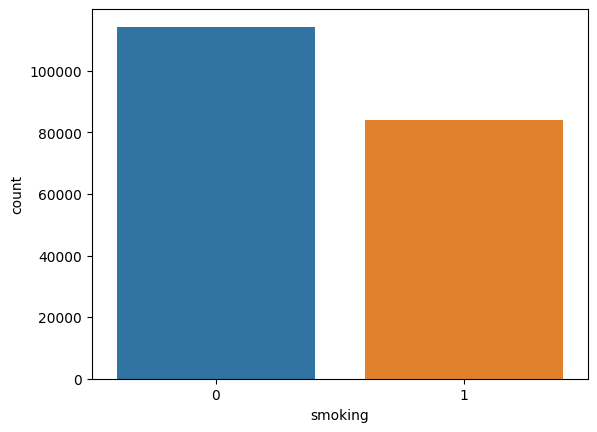

In [44]:
sns.countplot(data=df, x='smoking')

In [45]:
df.columns

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

In [46]:
target = ['smoking']
discrete = ['age', 'height(cm)', 'weight(kg)', 'systolic', 'relaxation', 
           'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL',
           'LDL', 'AST', 'ALT', 'Gtp']
continous = ['waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hemoglobin',
             'serum creatinine']
binary = ['hearing(left)', 'hearing(right)', 'dental caries']
nominal = ['Urine protein']

num_var = discrete + continous


In [47]:
# for var in num_var:
#     sns.histplot(data=df, x=var, kde=True)
#     plt.title(f"Distribution of {var}")
#     plt.show()   

In [48]:
df[num_var].describe().T

,count,mean,std,min,25%,50%,75%,max
age,198240.0,44.271418,11.886308,20.0,40.0,40.0,55.0,85.0
height(cm),198240.0,165.153375,8.895587,130.0,160.0,165.0,170.0,190.0
weight(kg),198240.0,66.906709,12.656868,30.0,55.0,65.0,75.0,135.0
systolic,198240.0,122.301488,12.920634,71.0,113.0,121.0,130.0,233.0
relaxation,198240.0,76.701085,9.135720,40.0,70.0,77.0,82.0,146.0
fasting blood sugar,198240.0,98.547180,16.514779,46.0,90.0,96.0,103.0,423.0
Cholesterol,198240.0,196.009988,30.131156,55.0,175.0,196.0,217.0,445.0
triglyceride,198240.0,127.445632,67.330696,8.0,76.0,113.0,164.0,999.0
HDL,198240.0,56.135951,14.106668,4.0,46.0,54.0,65.0,359.0
LDL,198240.0,114.700858,31.601535,1.0,94.0,114.0,134.0,1860.0


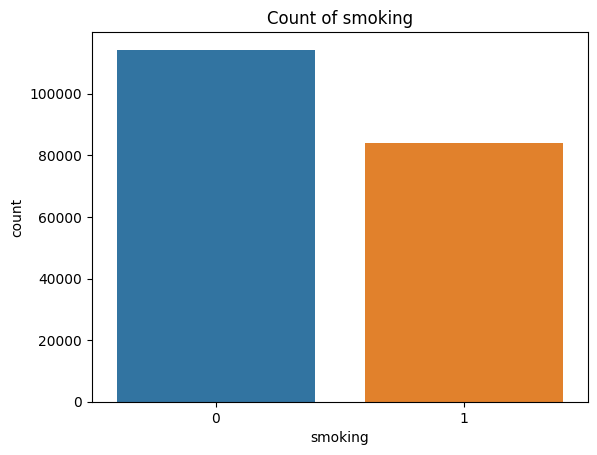

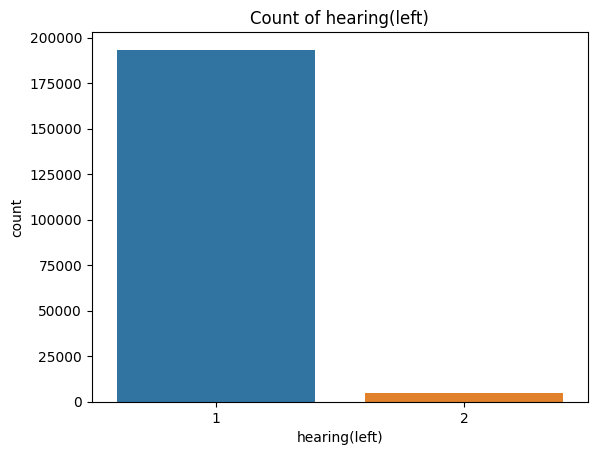

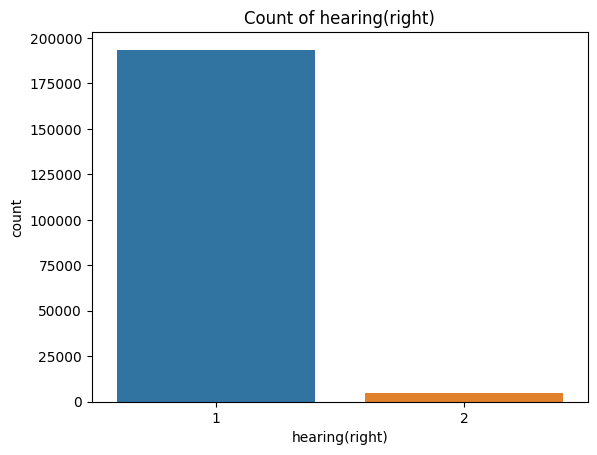

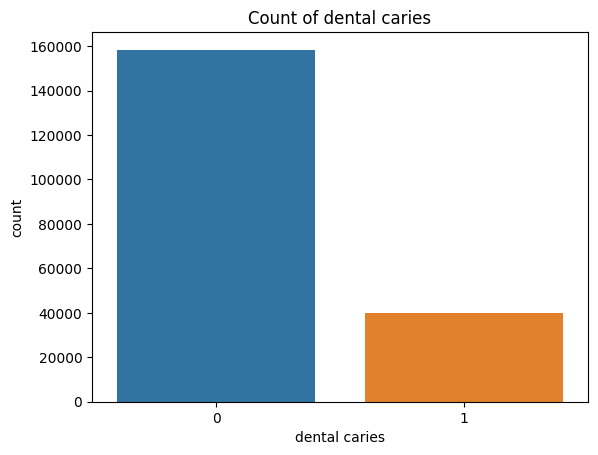

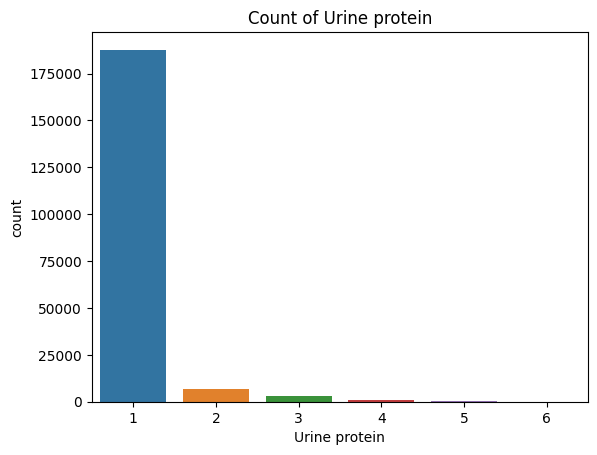

In [49]:
cat_var = target + binary + nominal

for var in cat_var:
    sns.countplot(data=df, x=var)
    plt.title(f"Count of {var}")
    plt.show()  

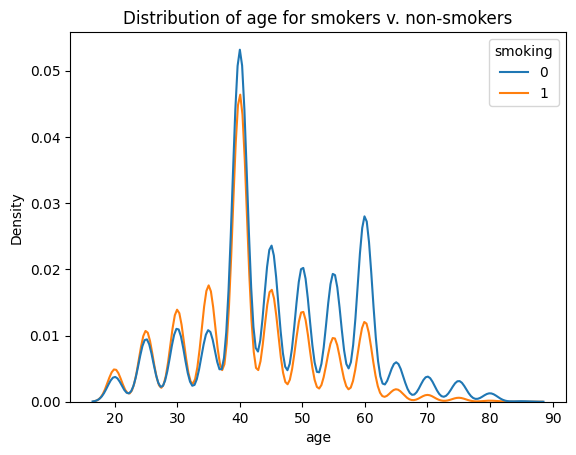

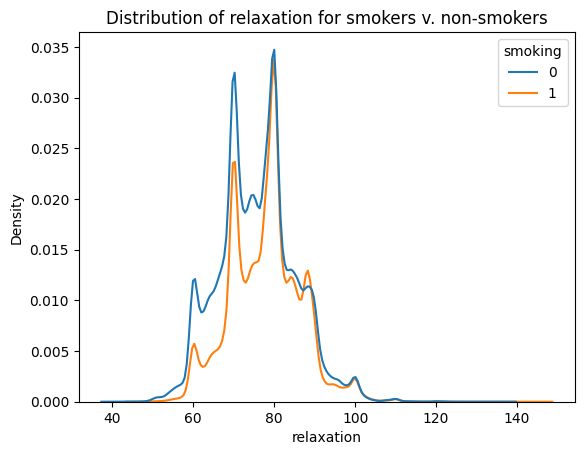

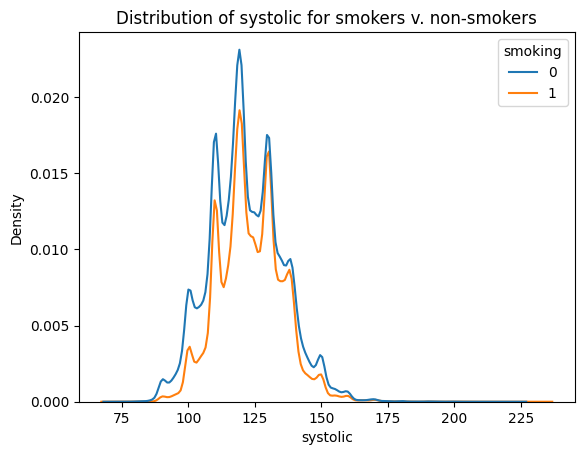

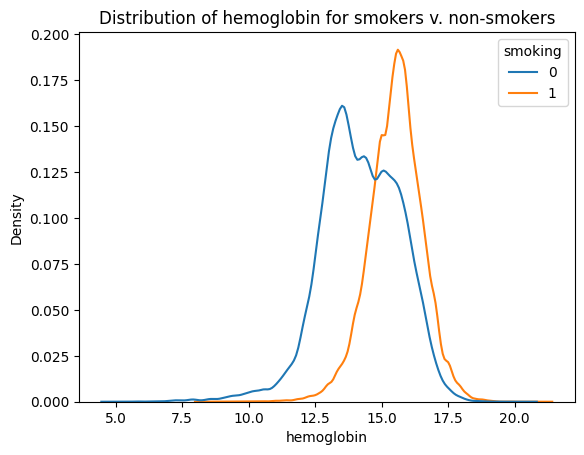

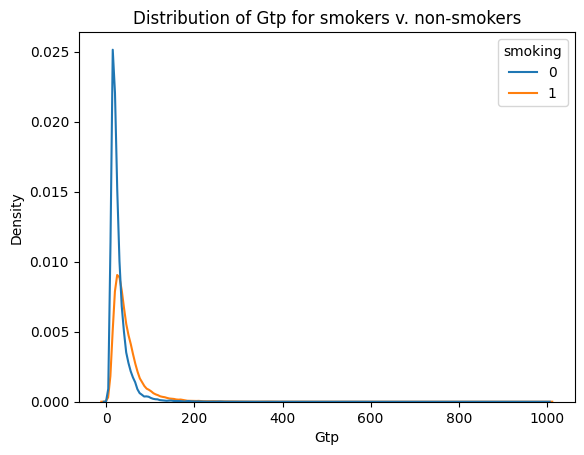

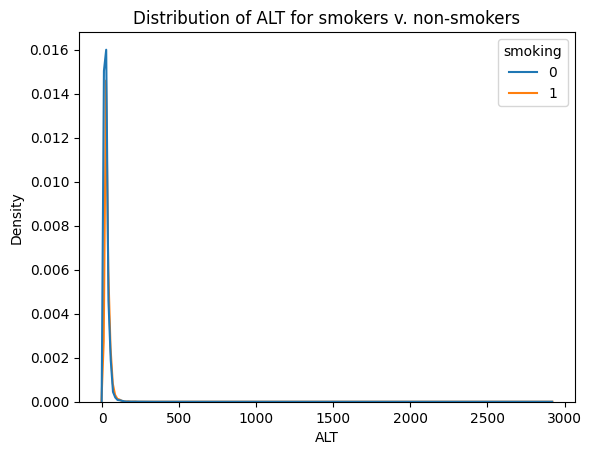

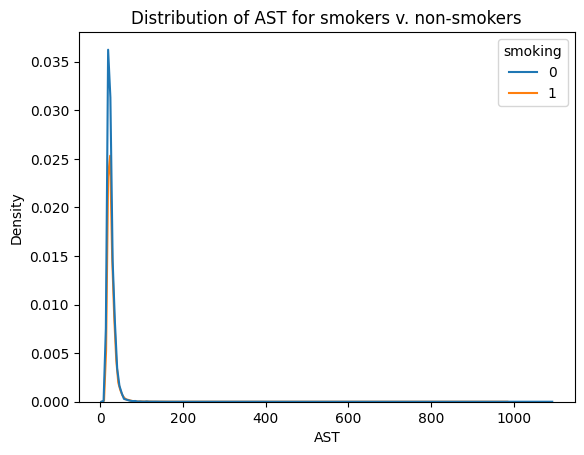

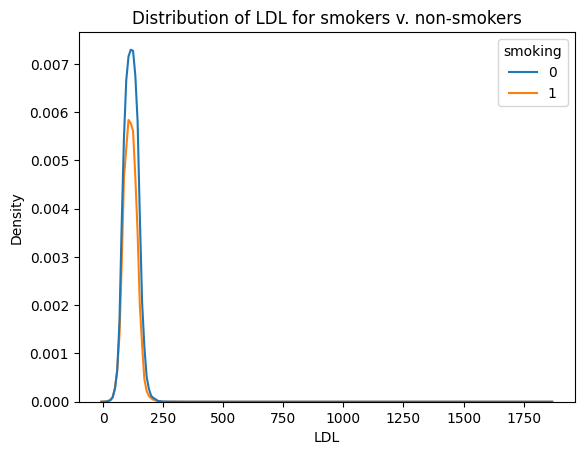

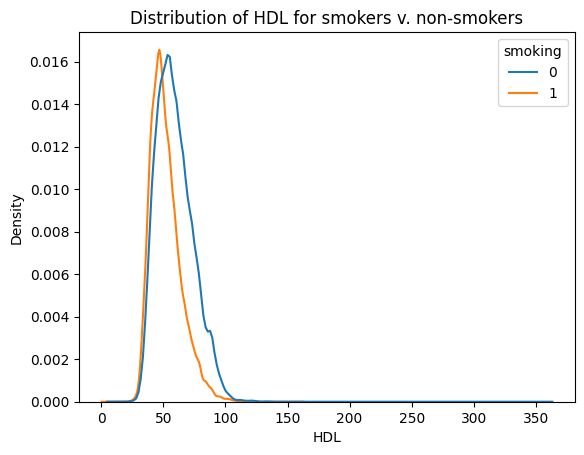

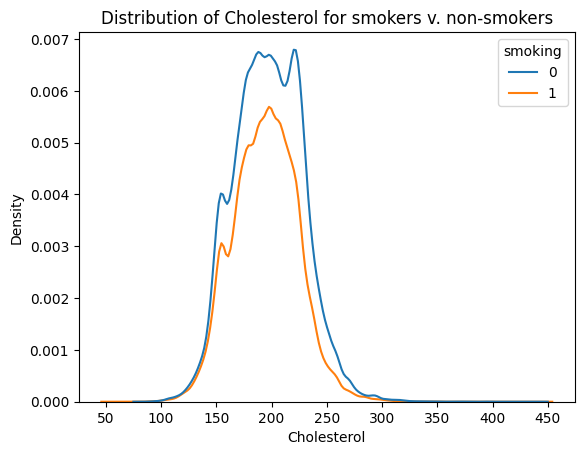

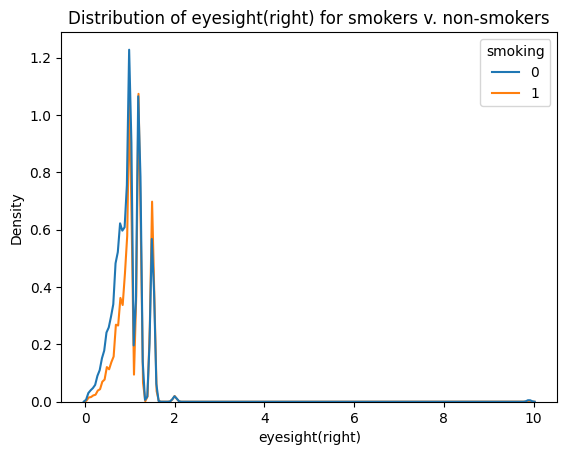

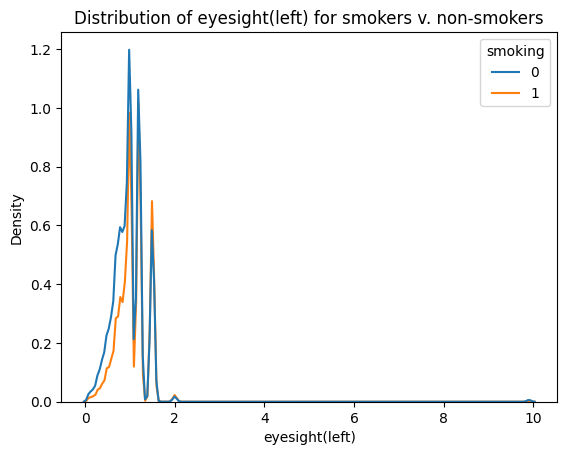

In [50]:
selected_var = ['age', 'relaxation', 'systolic', 'hemoglobin', 'Gtp', 'ALT', 'AST', 'LDL', 'HDL', 'Cholesterol', 'eyesight(right)', 'eyesight(left)']
for var in selected_var:
    sns.kdeplot(data=df, x=var, hue=target[0])
    plt.title(f"Distribution of {var} for smokers v. non-smokers")
    plt.show()   

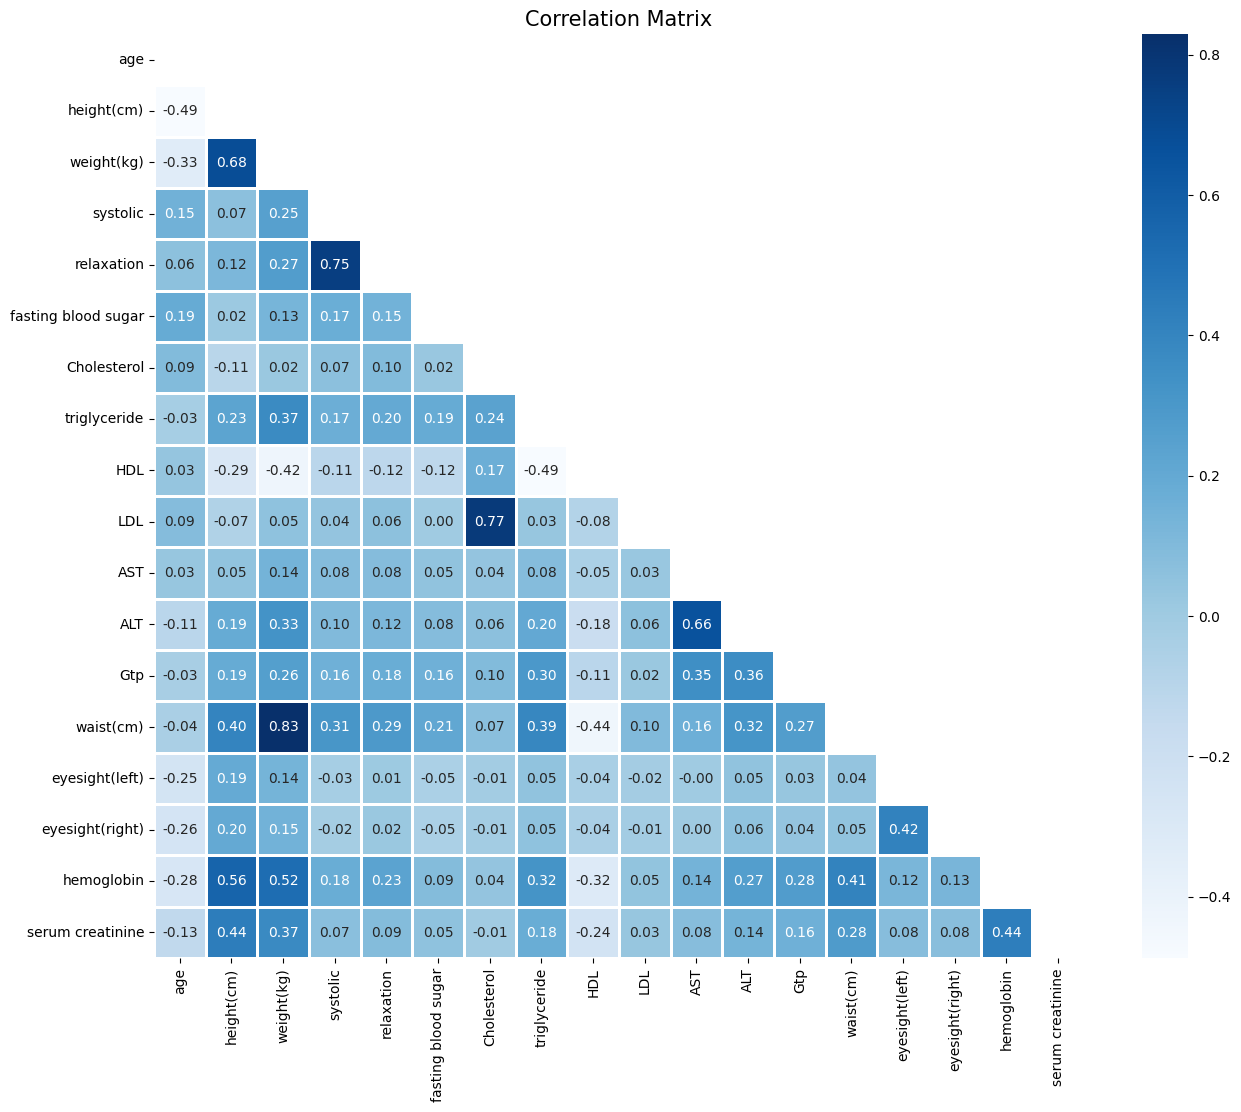

In [51]:
corr_matrix = df[num_var].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='Blues',  fmt='.2f', linewidths=2 )

plt.title('Correlation Matrix', fontsize=15)
plt.show()

Since the correlation values between any two variables is not greater than 90%, none of the attributes were removed.



In [52]:
df['bmi'] = df['weight(kg)'] / (df['height(cm)'] / 100) ** 2
features = list(df.columns)
features.pop(-2)

'smoking'

### Model selection process and parameter tuning

In [53]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

full_train = df_train_full.copy()
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train_full = df_train_full.smoking.values
y_train = df_train.smoking.values
y_val = df_val.smoking.values
y_test = df_test.smoking.values

del full_train['smoking']
del df_train['smoking']
del df_val['smoking']
del df_test['smoking']

X = df.drop(columns = ['smoking'], axis = 1)
Y = df['smoking']

In [54]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

def graph_roc(y,y_pred):
    fpr , tpr , thresholds = metrics.roc_curve(y, y_pred)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr,label='Model')
    plt.plot([0, 1], [0, 1],label='Random', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()
    # print(metrics.auc(fpr, tpr))


def met(y,y_pred,above_average):
    print('Model Accuracy:',round(metrics.accuracy_score(y, above_average),4))
    print('ROC:',round(roc_auc_score(y, y_pred),4))
    print((metrics.confusion_matrix(y, above_average)/metrics.confusion_matrix(y, above_average).sum()).round(4))


#### Logistic Regression

Model Accuracy: 0.7408
ROC: 0.8279
[[0.4456 0.132 ]
 [0.1272 0.2951]]


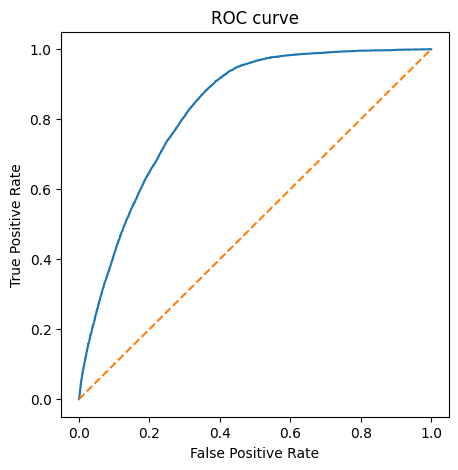

In [55]:
def train(df, y,  c=1.0):
    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000, random_state=1)
    model.fit(df, y)      
    return model

def predict(df,model):
    y_pred = model.predict_proba(df)[:, 1]    
    return y_pred

model = train(df_train, y_train)
y_pred = predict(df_val,model)
above_average = (y_pred >= 0.5)
met(y_val,y_pred,above_average)
graph_roc(y_val,y_pred)

Determine best C for logistic regression

In [56]:
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
skf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 42)

for c in tqdm([0.01, 0.1, 1.0 , 0.5, 10,15]):

    scores = []

    for train_idx ,val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.smoking.values
        y_val = df_val.smoking.values
        
        del df_train['smoking']
        del df_val['smoking']
        
        model = train(df_train,y_train,c)
        y_pred = predict(df_val,model)

        roc_auc = metrics.roc_auc_score(y_val,y_pred)
        scores.append(roc_auc)

    print('C=%s %f +- %f' % (c,np.mean(scores),np.std(scores)))

  0%|          | 0/6 [00:00<?, ?it/s]

C=0.01 0.827580 +- 0.002544
C=0.1 0.827536 +- 0.002564
C=1.0 0.827558 +- 0.002522
C=0.5 0.827500 +- 0.002581
C=10 0.827502 +- 0.002557
C=15 0.827533 +- 0.002503


Model Accuracy: 0.7435
ROC: 0.8297
[[0.4477 0.1323]
 [0.1242 0.2958]]


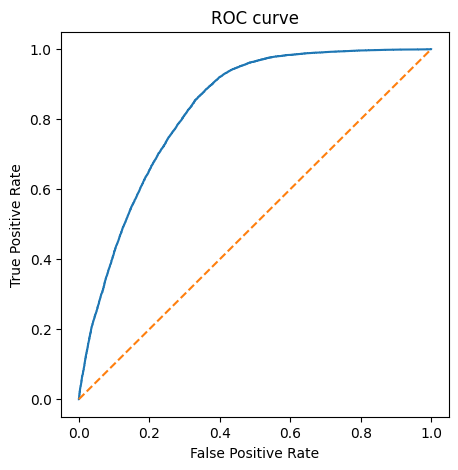

In [57]:
model = train(df_train, y_train,1.0)
y_pred = predict(df_val,model)
above_average = (y_pred >= 0.5)
met(y_val,y_pred,above_average)
graph_roc(y_val,y_pred)

Select C=1.0 as best tuning parameter for logistic regression

C=1.0 0.827558 +- 0.002522


#### Random Forest

In [58]:
rf = RandomForestClassifier(random_state=29)
rf.fit(df_train, y_train)

RandomForestClassifier(random_state=29)

Model Accuracy: 0.7827
ROC: 0.8642
[[0.4438 0.1362]
 [0.0811 0.3389]]


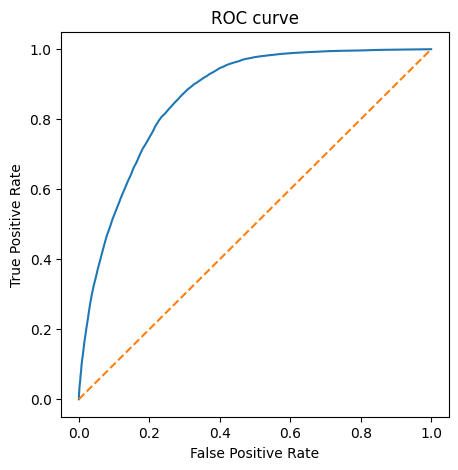

In [59]:
y_pred = rf.predict_proba(df_val)[:, 1]
above_average = (y_pred >= 0.5)
met(y_val,y_pred,above_average)
graph_roc(y_val,y_pred)

In [60]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 29,
 'verbose': 0,
 'warm_start': False}

The untuned RF has an accuracy of 86.05% on the validation dataset.

In [61]:
n_estimators = [100,150, 200,250, 300,350]
max_depth =  [10,15,20,25,30,35]
all_scores =[]
for m in max_depth:
    for n in n_estimators:
        random_rf = RandomForestClassifier(n_estimators=n,max_depth=m,random_state=29,n_jobs=-1)
        random_rf.fit(full_train, y_train_full)
        y_pred_rf = random_rf.predict_proba(df_val)[:, 1] 
        all_scores.append((m,n,metrics.roc_auc_score(y_val, y_pred_rf ),metrics.accuracy_score(y_val,y_pred_rf>=0.5)))

In [62]:
df_all_scores = pd.DataFrame(all_scores, columns=['max_depth','n_estimator','roc','acc'])
df_all_scores.round(4).sort_values(by='acc',ascending=False)

,max_depth,n_estimator,roc,acc
35,35,350,1.0000,1.0000
34,35,300,1.0000,1.0000
33,35,250,1.0000,1.0000
32,35,200,1.0000,1.0000
31,35,150,1.0000,1.0000
30,35,100,1.0000,1.0000
26,30,200,1.0000,0.9999
24,30,100,1.0000,0.9999
25,30,150,1.0000,0.9999
28,30,300,1.0000,0.9999


<Axes: xlabel='None-n_estimator', ylabel='max_depth'>

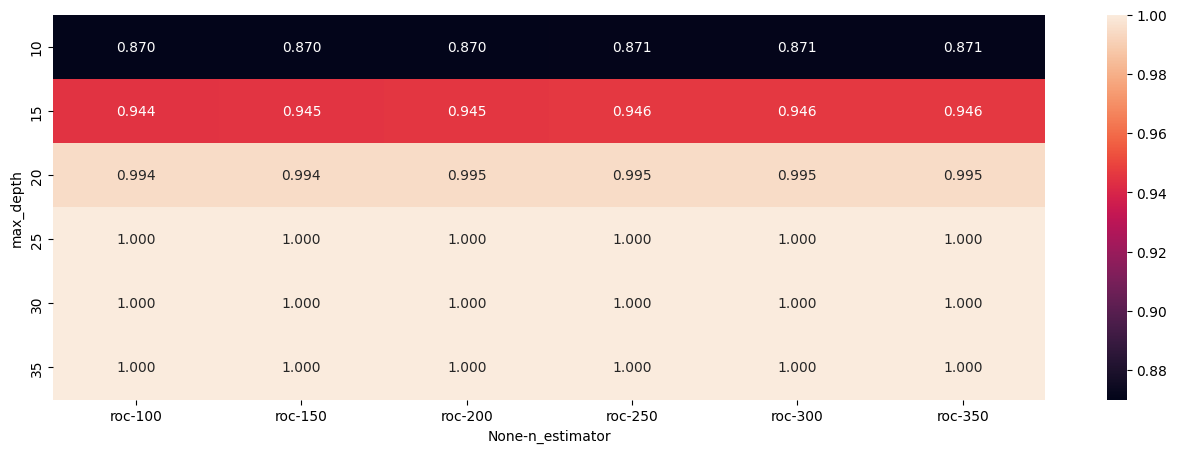

In [63]:
roc_pivot = df_all_scores.pivot(index='max_depth', columns=['n_estimator'],values=['roc'])
roc_pivot.round(4)
plt.figure(figsize = (16,5))
sns.heatmap(roc_pivot,annot=True,fmt='.3f')

<Axes: xlabel='None-n_estimator', ylabel='max_depth'>

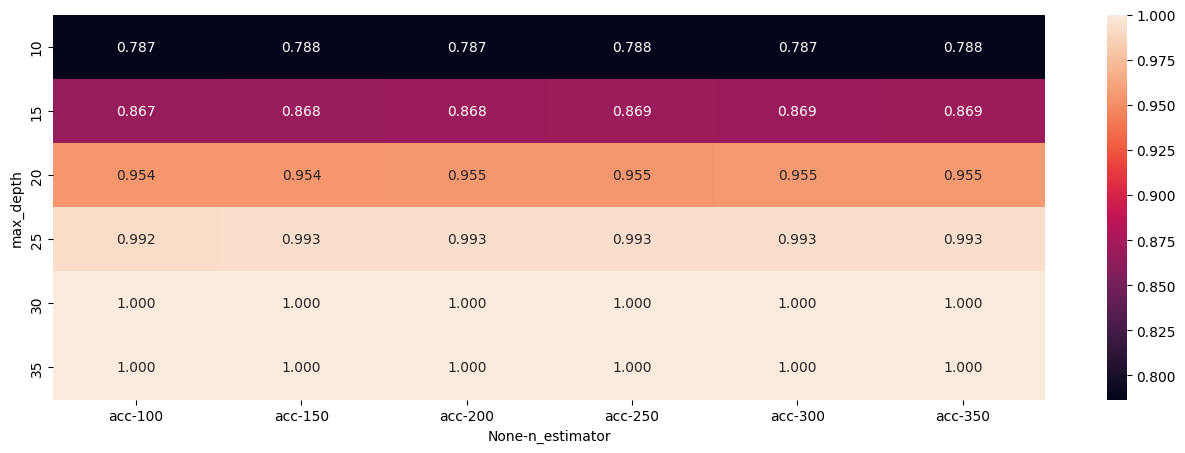

In [64]:
acc_pivot = df_all_scores.pivot(index='max_depth', columns=['n_estimator'],values=['acc'])
acc_pivot.round(4)
plt.figure(figsize = (16,5))
sns.heatmap(acc_pivot,annot=True,fmt='.3f')

In [65]:
rf = RandomForestClassifier(n_estimators=25,max_depth=200,random_state=29,n_jobs=-1)
rf.fit(full_train, y_train_full)

RandomForestClassifier(max_depth=200, n_estimators=25, n_jobs=-1,
                       random_state=29)

In [66]:
rf_pred = rf.predict_proba(df_test)[:, 1] 
print(metrics.accuracy_score(y_test,rf_pred>=0.5))
print(metrics.roc_auc_score(y_test,rf_pred))


0.7721953188054883
0.8544717780775095


In [67]:
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importances.sort_values(by='Importance', ascending=False)

,Feature,Importance
15,hemoglobin,0.117879
1,height(cm),0.099363
20,Gtp,0.093519
12,triglyceride,0.078956
2,weight(kg),0.053400
14,LDL,0.047319
13,HDL,0.046304
11,Cholesterol,0.045703
19,ALT,0.043573
10,fasting blood sugar,0.042266


#### XGboost

In [68]:
xgboost = XGBClassifier()
xgboost.fit(df_train,y_train)
y_pred = xgboost.predict(df_val)
metrics.roc_auc_score(y_val, y_pred ),metrics.accuracy_score(y_val,y_pred>=0.5)

(0.780938780694804, 0.7796519326565358)

In [69]:
dtrain = xgb.DMatrix(df_train, label= y_train , feature_names = features)
dval = xgb.DMatrix(df_val, label= y_val , feature_names = features)

watchlist = [(dtrain,'train'),(dval,'val')]

In [70]:
xgb_scores = []

for x in range(3,10):    
    xgb_params = {
        'eta': 0.1, 
        'max_depth': x,
        'min_child_weight': 1,
        'objective': 'binary:logistic',
        'nthread': 8,
        'eval_metric': 'auc',
        'seed': 29,
        'verbosity': 1,
    }
    xgb_model = xgb.train(xgb_params,dtrain,verbose_eval=5,evals=watchlist,num_boost_round=100)
    y_pred = xgb_model.predict(dval)
    xgb_scores.append((x,metrics.roc_auc_score(y_val, y_pred ),metrics.accuracy_score(y_val,y_pred>=0.5)))

[0]	train-auc:0.80355	val-auc:0.80393
[5]	train-auc:0.82209	val-auc:0.82183
[10]	train-auc:0.82649	val-auc:0.82644
[15]	train-auc:0.82948	val-auc:0.83010
[20]	train-auc:0.83265	val-auc:0.83326
[25]	train-auc:0.83664	val-auc:0.83730
[30]	train-auc:0.84011	val-auc:0.84077
[35]	train-auc:0.84290	val-auc:0.84349
[40]	train-auc:0.84489	val-auc:0.84552
[45]	train-auc:0.84671	val-auc:0.84737
[50]	train-auc:0.84833	val-auc:0.84908
[55]	train-auc:0.84979	val-auc:0.85059
[60]	train-auc:0.85095	val-auc:0.85170
[65]	train-auc:0.85210	val-auc:0.85275
[70]	train-auc:0.85317	val-auc:0.85368
[75]	train-auc:0.85413	val-auc:0.85448
[80]	train-auc:0.85488	val-auc:0.85513
[85]	train-auc:0.85554	val-auc:0.85562
[90]	train-auc:0.85617	val-auc:0.85610
[95]	train-auc:0.85671	val-auc:0.85657
[99]	train-auc:0.85713	val-auc:0.85688
[0]	train-auc:0.81760	val-auc:0.81822
[5]	train-auc:0.82774	val-auc:0.82784
[10]	train-auc:0.83254	val-auc:0.83256
[15]	train-auc:0.83647	val-auc:0.83644
[20]	train-auc:0.84017	val-au

picking best parameters for xgboost 

max_depth = 6

eta = 0.1

In [71]:
xgb_all_scores = pd.DataFrame(xgb_scores, columns=['max_depth','roc','acc'])
xgb_all_scores.round(3).sort_values(by='roc',ascending=False)

,max_depth,roc,acc
6,9,0.866,0.780
4,7,0.865,0.779
5,8,0.865,0.780
3,6,0.864,0.778
2,5,0.862,0.776
1,4,0.860,0.774
0,3,0.857,0.772


In [72]:
xgb_all_scores.round(3).sort_values(by='acc',ascending=False)

,max_depth,roc,acc
5,8,0.865,0.780
6,9,0.866,0.780
4,7,0.865,0.779
3,6,0.864,0.778
2,5,0.862,0.776
1,4,0.860,0.774
0,3,0.857,0.772


#### Picking XGboost to be less complex than Random Forest with the same performance.

In [73]:
# XGB_cv_routine = cross_val_score(XGBClassifier(tree_method='hist',
#                                                n_estimators=600,
#                                                learning_rate=0.1,
#                                                colsample_bytree=0.5),
#                                  X,
#                                  Y,
#                                  scoring='roc_auc',
#                                  cv=skf,
#                                  n_jobs=-1)

# print(
#     f"The average oof ROC-AUC score of the XGB model is {XGB_cv_routine.mean()}")